In [1]:
import xarray as xr
import numpy as np
from jax import config
config.update("jax_enable_x64", True)
from tqdm import tqdm
from jax import numpy as jnp
from diffrax import diffeqsolve, ODETerm, SemiImplicitEuler, SaveAt
from interpax import Interpolator2D

In [2]:
flds = xr.open_dataset("./all-fields.nc")

In [3]:
flds

<xarray.Dataset>
Dimensions:    (t: 4000, x: 32)
Coordinates:
  * t          (t) float64 0.0 0.5 1.0 1.5 ... 1.998e+03 1.999e+03 2e+03
  * x          (x) float64 0.2641 0.7924 1.321 1.849 ... 15.05 15.58 16.11 16.64
Data variables:
    force-(x)  (t, x) float64 ...

In [4]:
xax = flds.coords["x"].data
tax = flds.coords["t"].data

dx = xax[1]-xax[0]
xmax = xax[-1] + dx/2.
dt = tax[1]-tax[0]

nv_part = 128
nx_part = xax.size

# initialize particles
xi = np.repeat(xax, nv_part)
vi = np.tile(np.linspace(-6, 6, nv_part), nx_part)

In [5]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'v ($v_{th}$)')

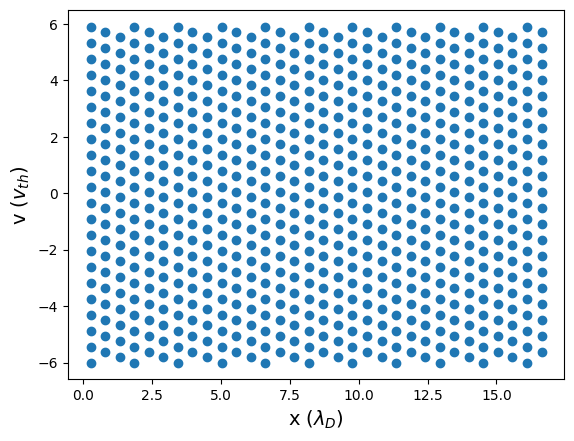

In [6]:
plt.scatter(xi[::6], vi[::6])
plt.xlabel("x ($\lambda_D$)", fontsize=14)
plt.ylabel("v ($v_{th}$)", fontsize=14)

In [7]:
nt = 2000
xp = np.zeros((nt, xi.size))
vp = np.zeros((nt, vi.size))

In [8]:
padded_x = np.concatenate([xax[0:1]-dx, xax, xax[-1:]+dx])
for it, tt in tqdm(enumerate(tax[:nt])):

    # initialize (this should just be done outside the loop)
    if it == 0:
        xp[it] = xi + dt * vi
        # padded_fld = np.concatenate([flds["force-(x)"][it].data[-1:], flds["force-(x)"][it].data, flds["force-(x)"][it].data[0:1]])
        # fp = np.interp(xp[it], padded_x, padded_fld)
        fp = np.interp(xp[it], xax, flds["force-(x)"][it].data, period=xmax)
        vp[it] = vi + dt * fp
    else:
        xp[it] = xp[it-1] + dt * vp[it-1]
        fp = np.interp(xp[it], xax, flds["force-(x)"][it].data, period=xmax)
        # padded_fld = np.concatenate([flds["force-(x)"][it].data[-1:], flds["force-(x)"][it].data, flds["force-(x)"][it].data[0:1]])
        # fp = np.interp(xp[it], padded_x, padded_fld)
        vp[it] = vp[it-1] + dt * fp

    # boundary condition
    xp = np.where(xp > xmax, xp - xmax, np.where(xp < 0, xp + xmax, xp))

2000it [01:09, 28.71it/s]


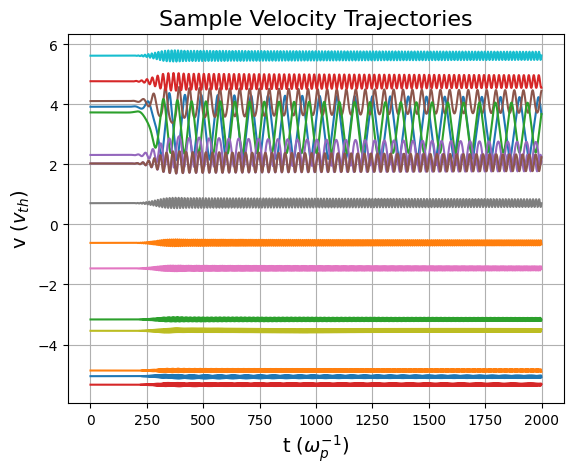

In [9]:
def sample_trajectories(n_traj):
    ipart = np.random.choice(np.arange(xi.size), n_traj, replace=False)
    for ip in ipart:
        plt.plot(vp[:, ip])
    plt.grid()
    plt.ylabel("v ($v_{th}$)", fontsize=14)
    plt.xlabel("t ($\omega_p^{-1}$)", fontsize=14)
    plt.title("Sample Velocity Trajectories", fontsize=16)
sample_trajectories(16)

Array([ 0.15449711,  0.15787964,  0.15545833,  0.14842569,  0.13678179,
        0.1204716 ,  0.09989914,  0.07593532,  0.04955477,  0.02179574,
       -0.00638861, -0.03426918, -0.06108288, -0.08622004, -0.10899539,
       -0.12862417, -0.14418789, -0.15458344, -0.15878675, -0.15626429,
       -0.14805997, -0.13514499, -0.11633117, -0.09063284, -0.05959334,
       -0.02618863,  0.00819295,  0.04239134,  0.07417167,  0.10150468,
        0.12490363,  0.14349018], dtype=float64)

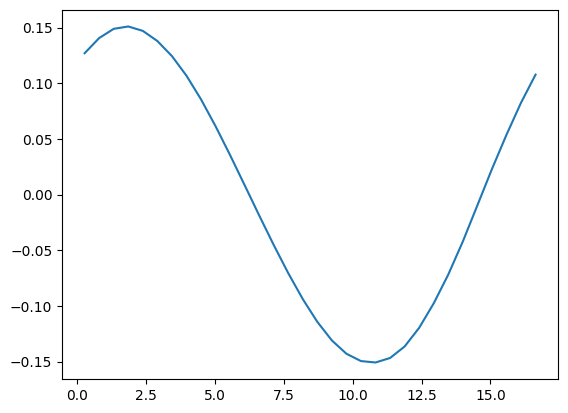

In [43]:
plt.plot(xax, efield(jnp.full_like(xax, 200.25), xax)) #np.linspace(2.5, 10, 32)))
# plt.plot(efield(jnp.full_like(xax, 200.25), np.linspace(2.5, 10, 32)))

In [49]:
def dxdt(t, y, args):
    return y

efield = Interpolator2D(tax, xax, flds["force-(x)"].data, method="linear", period=(None, xmax))

def dvdt(t, y, args):
    # it = (t/0.5).astype(jnp.int32)
    # print(it)
    # return jnp.interp(y[0], xax, args["e"][it], period=xmax)
    return efield(jnp.full_like(y, t), y)

In [50]:
from equinox.internal import ω
import diffrax


class Leapfrog(SemiImplicitEuler):
    """Semi-implicit Euler's method.

    Symplectic method. Does not support adaptive step sizing. Uses 1st order local
    linear interpolation for dense/ts output.
    """

    def step(
        self,
        terms,
        t0,
        t1,
        y0,
        args,
        solver_state,
        made_jump,
    ):
        del solver_state, made_jump

        term_1, term_2 = terms
        y0_1, y0_2 = y0

        control1 = term_1.contr(t0, t1)
        control2 = term_2.contr(t0, t1)
        y1_1 = (y0_1**ω + term_1.vf_prod(t0, y0_2, args, control1) ** ω).ω
        y1_1 = jnp.where(y1_1 > xmax, y1_1 - xmax, jnp.where(y1_1 < 0, y1_1 + xmax, y1_1))
        
        y1_2 = (y0_2**ω + term_2.vf_prod(t0, y1_1, args, control2) ** ω).ω

        y1 = (y1_1, y1_2)
        dense_info = dict(y0=y0, y1=y1)
        return y1, None, dense_info, None, diffrax.RESULTS.successful


In [51]:
tmax = 2000
dt = 0.5
result = diffeqsolve((ODETerm(dxdt), ODETerm(dvdt)), solver=Leapfrog(), t0=0., t1=tmax, dt0=dt, y0=(xi, vi), 
                     args={"e": flds["force-(x)"].data}, 
                     saveat=SaveAt(ts=np.linspace(1, tmax-10, int(tmax//dt//2))))






In [52]:
result

Solution(
  t0=f64[],
  t1=f64[],
  ts=f64[2000],
  ys=(f64[2000,4096], f64[2000,4096]),
  interpolation=None,
  stats={
    'max_steps':
    4096,
    'num_accepted_steps':
    i64[],
    'num_rejected_steps':
    i64[],
    'num_steps':
    i64[]
  },
  result=i64[],
  solver_state=None,
  controller_state=None,
  made_jump=None
)

In [53]:
result.ys[1].shape

(2000, 4096)

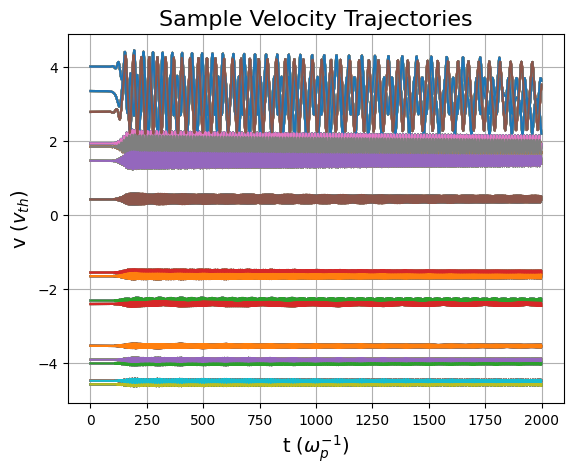

In [58]:
def sample_trajectories(n_traj):
    ipart = np.random.choice(np.arange(xi.size), n_traj, replace=False)
    for ip in ipart:
        # plt.plot(vp[:, ip])
        plt.plot(result.ys[1][:, ipart])
    plt.grid()
    plt.ylabel("v ($v_{th}$)", fontsize=14)
    plt.xlabel("t ($\omega_p^{-1}$)", fontsize=14)
    plt.title("Sample Velocity Trajectories", fontsize=16)
sample_trajectories(16)
